In [2]:
from fastai.text.all import *
from pathlib import Path
import random

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [3]:
def get_oversampled_df(data_path):
    df = pd.read_csv(data_path)

    max_dialog = df['speaker'].value_counts().max()

    dfs_oversampled = [df]
    for _, group in df.groupby('speaker'):
        rand_mult = random.uniform(0.85, 1.15)
        sample_amt_to_max = max_dialog - len(group)
        dfs_oversampled.append(group.sample(int(sample_amt_to_max * rand_mult), replace=True))
    return pd.concat(dfs_oversampled)

<Axes: >

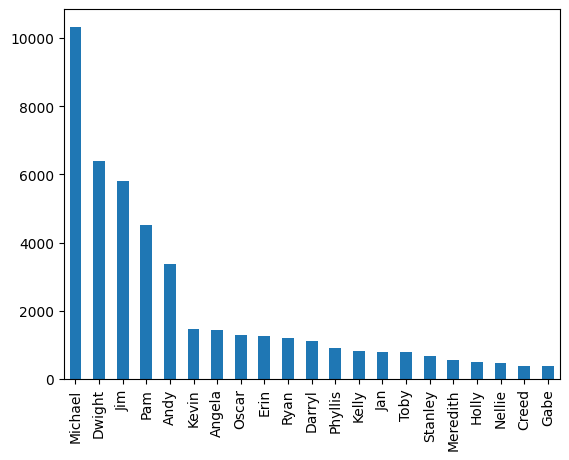

In [4]:
train_path = Path('../data/train21_shuffled.csv')
test_path = Path('../data/test21_shuffled.csv')
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df['speaker'].value_counts().plot(kind='bar')


<Axes: >

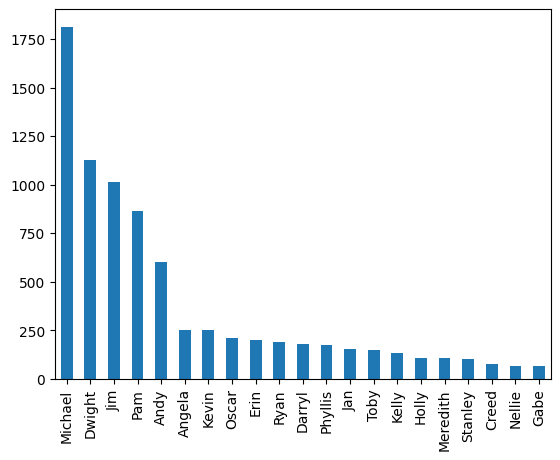

In [6]:
df_test['speaker'].value_counts().plot(kind='bar')

In [5]:
dls_lm = TextDataLoaders.from_df(df, text_col='line_text', is_lm=True, valid_pct=0.1, shuffle=True)

In [6]:
dls_lm.show_batch()

,text,text_
0,xxbos xxmaj he just wo n't go down . xxmaj it 's as if he 's excited by all this paper . xxbos xxmaj what 's wrong ? xxmaj where 's your costume ? xxbos [ knocking on door ] xxmaj hmm ? xxbos xxmaj yeah . xxbos [ holds up cell phone showing video of xxmaj angela talking to her cats ] xxmaj for a xxunk day . [ laughs ],xxmaj he just wo n't go down . xxmaj it 's as if he 's excited by all this paper . xxbos xxmaj what 's wrong ? xxmaj where 's your costume ? xxbos [ knocking on door ] xxmaj hmm ? xxbos xxmaj yeah . xxbos [ holds up cell phone showing video of xxmaj angela talking to her cats ] xxmaj for a xxunk day . [ laughs ] xxbos
1,"are you kidding me ? xxmaj dwight , come on ! xxbos xxmaj wha , it's- xxbos xxmaj god i can not wait to get pregnant and have babies ! xxbos xxmaj alright . xxmaj for five hundred points , i will wear a dress to work . [ laughter ] xxbos xxmaj well , it 's the … carry the four … and … it does n't work . xxbos xxmaj","you kidding me ? xxmaj dwight , come on ! xxbos xxmaj wha , it's- xxbos xxmaj god i can not wait to get pregnant and have babies ! xxbos xxmaj alright . xxmaj for five hundred points , i will wear a dress to work . [ laughter ] xxbos xxmaj well , it 's the … carry the four … and … it does n't work . xxbos xxmaj for"
2,"impossible ! xxbos xxmaj bye . xxbos xxmaj okay … [ puts pizza into xxmaj dwight 's mouth ] xxbos xxmaj do you , do you want a xxunk ? xxbos xxmaj oh , xxmaj i 'm really worried that xxmaj i 'm going to say it . xxbos xxmaj every time there 's a silence , your brain 's like ' heh - heh - huh - huh ' [ imitating","! xxbos xxmaj bye . xxbos xxmaj okay … [ puts pizza into xxmaj dwight 's mouth ] xxbos xxmaj do you , do you want a xxunk ? xxbos xxmaj oh , xxmaj i 'm really worried that xxmaj i 'm going to say it . xxbos xxmaj every time there 's a silence , your brain 's like ' heh - heh - huh - huh ' [ imitating crying"
3,"xxmaj i 'm … here , xxmaj jan . xxbos i ca n't go back to that . xxbos i was just wondering , what kind of jobs do you guys have ? xxbos xxmaj maybe because you hated her present so much . xxbos xxmaj in xxmaj german ! xxmaj xxunk xxunk xxunk xxunk , alter xxunk die xxmaj xxunk , xxmaj xxunk xxunk die xxmaj xxunk , xxunk xxunk xxmaj","i 'm … here , xxmaj jan . xxbos i ca n't go back to that . xxbos i was just wondering , what kind of jobs do you guys have ? xxbos xxmaj maybe because you hated her present so much . xxbos xxmaj in xxmaj german ! xxmaj xxunk xxunk xxunk xxunk , alter xxunk die xxmaj xxunk , xxmaj xxunk xxunk die xxmaj xxunk , xxunk xxunk xxmaj xxunk"
4,". xxunk ' xxmaj nice ! xxbos xxmaj yes . xxbos xxmaj well … i … xxmaj hey . xxmaj you 've never met me before . xxbos xxmaj so since you guys already ate , you wo n't be eating the stuff you brought with you for lunch , will you ? [ walks into kitchen ] xxmaj oh , wow , xxmaj stanley . xxmaj is that egg salad ?","xxunk ' xxmaj nice ! xxbos xxmaj yes . xxbos xxmaj well … i … xxmaj hey . xxmaj you 've never met me before . xxbos xxmaj so since you guys already ate , you wo n't be eating the stuff you brought with you for lunch , will you ? [ walks into kitchen ] xxmaj oh , wow , xxmaj stanley . xxmaj is that egg salad ? xxmaj"
5,", like the xxmaj french xxmaj xxunk , or the xxmaj black xxmaj xxunk , or xxunk . xxmaj it 's just a club . xxmaj guys talking , you know . xxbos xxmaj can i sit down for a second ? xxbos xxmaj you look great . xxbos xxmaj you know what , i feel like one of those old xxunk xxunk . xxmaj with the eye patch . [ in","like the xxmaj french xxmaj xxunk , or the xxmaj black xxmaj xxunk , or xxunk . xxmaj it 's just a club . xxmaj guys talking , you know . xxbos xxmaj can i sit down for a second ? xxbos xxmaj you look great . xxbos xxmaj you know what , i feel like one of those old xxunk xxunk . xxmaj with the eye patch . [ in pirate"
6,. xxbos i know . xxmaj i 'm taking them down . xxbos xxmaj pam . xxmaj ms . xxmaj beasley if xxunk xxunk ! xxmaj janet xxmaj 

In [7]:
data_dir = Path('../data')
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1, path=data_dir)

In [8]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.263573,3.604970,0.302047,36.780590,00:26
1,3.691440,3.416972,0.321637,30.476995,00:25
2,3.570127,3.393032,0.328448,29.756031,00:26
3,3.501609,3.383716,0.329308,29.480112,00:26
4,3.441533,3.367964,0.331692,29.019377,00:25
5,3.398895,3.356099,0.332402,28.677094,00:25
6,3.361833,3.346364,0.335143,28.399286,00:25
7,3.321589,3.337751,0.336317,28.155745,00:25
8,3.296000,3.334310,0.336995,28.059004,00:25
9,3.293357,3.334221,0.336795,28.056522,00:25


In [9]:
cur_encoder='temp_10epoch_raw_data'
learn.save_encoder(cur_encoder)

In [13]:
df_oversampled = get_oversampled_df(train_path)
dls_clas = TextDataLoaders.from_df(df_oversampled, text_col='line_text', label_col='speaker', shuffle_train=True, text_vocab=dls_lm.vocab)


In [14]:
dls_test = TextDataLoaders.from_df(df_test, text_col='line_text', label_col='speaker', shuffle_train=False, drop_last=False)

In [51]:
dls_clas.show_batch()

,text,category
0,"xxbos xxmaj i 've really learned from the xxunk . xxmaj the great xxunk , xxmaj drew xxmaj xxunk , xxmaj ryan xxmaj xxunk , uh , the xxmaj xxunk guy not so much . xxmaj he 's more the signing , xxmaj wayne xxmaj xxunk . xxmaj um , xxmaj robin xxmaj williams . xxmaj oh , man , would i love to go head - to - head with him . xxmaj oh ! xxmaj that would be exciting . [ as xxmaj robin xxmaj williams ] ' hi . xxmaj i 'm xxmaj xxunk from xxmaj xxunk . ' xxmaj well , xxmaj i 'm xxmaj xxunk from xxmaj xxunk . xxmaj nanoo , nanoo . xxmaj xxunk , xxunk . [ as xxmaj robin xxmaj williams ] ' that 's xxmaj good morning , xxmaj vietnam ! ' xxmaj well , hello to you . xxmaj",Michael
1,"xxbos xxmaj no . xxmaj no , that is not all . xxmaj let me tell you what real life is like . xxmaj the men dry up , and the nights get lonely . xxmaj the only calls on your machine are for collection xxunk about that pair of motorcycle boots you never even wore . xxmaj you xxunk your old high school boyfriend online , go to his daughter 's soccer games , and make a scene . xxmaj you buy a diamond ring for yourself , wear it on your right hand , and tell yourself , you 're all you need . xxmaj one day , you 're alone , tired . xxmaj at your feet , a dying bird . xxmaj but where did it come from ? xxmaj why did you kill it ? xxmaj is it because in some strange way it is",Nellie
2,"xxbos xxmaj well , uh , okay . xxmaj um . xxmaj it 's really great to be here tonight , with the xxmaj ferris wheel , the band , and the low sunlight . xxmaj i 'm gon na miss you all when i go to xxmaj costa xxmaj rica , and if i keep drinking beer like this , xxmaj i 'm gon na have to take a leak - a. [ laughter from audience , xxmaj michael looks at camera xxunk ] xxmaj look , on a more personal note , i just want to say thanks , you know , no matter what was going on in my life , you know , my divorce , or the xxunk battle , or that thing with my sister , it was just nice knowing i had a , a xxunk place to come to where …",Toby
3,"xxbos [ to xxmaj andy ] i talked to corporate . xxmaj turns out there have been 12 reports of xxunk printers . xxmaj out of 400 , xxrep 3 0 . [ smiles ] xxmaj we 've xxunk . xxmaj every time it 's been user error . xxmaj they block the xxunk or something , i do n't know . xxmaj that 's why we have the fine print . xxmaj thank you for bringing this to our attention . xxmaj so xxmaj i 'd like to reward you for that . [ pulls out gift card ] xxmaj that 's god for five bucks at xxmaj dunkin ' xxmaj donuts . xxmaj any xxmaj dunkin ' xxmaj donuts . [ andy looks over at xxmaj darryl and xxmaj darryl motions for xxmaj andy to go to him ]",Gabe
4,"xxbos xxmaj oui , xxmaj oui , xxmaj monsieur . xxmaj from the xxmaj xxunk region , a nice firm xxunk . xxmaj also from the great state of xxmaj xxunk , an aged xxunk . xxmaj here you will find a xxunk style spread which has xxunk nicely with the air to form a light xxunk which i think you 'll find both challenging and delicious . xxmaj at that point , i would recommend you take a trip south of the border to the great state of xxmaj xxunk where you will find this fine xxmaj xxunk xxmaj cheese dressing . xxmaj if i may be so bold , it 's a lot of fun to let the xxunk take a little swim in the xxunk cheese . xxmaj bon appetit .",Andy
5,"xxbos [ crying ] i ca n't do this . xxmaj all the xxunk are gon na be different there . xxmaj i 'm not gon na be able to find my shows . xxmaj i 'm not going to start improv at level one , and i do n't think my xxunk will transfer . xxmaj ugh , and you know what ? i just figured out where i was supposed to go to vote . [ picks xxmaj world 's xxmaj best xxmaj boss mug out of the xxunk and puts it back on his desk ] i got ta call her , and xxmaj i 'm going to tell her , that i can not come . [ dials on his phone ]",Michael
6,"xxbos xxmaj last night was crazy . xxmaj xxunk ? xxmaj yeah . xxmaj he did a donut in a parking lot in front of a cop . xxmaj and then he yells , ' hey co

In [15]:
dls_test.show_batch()

,text,category
0,"xxbos [ runs over after walking over fire xxunk ] xxmaj hey ! i want to say something . xxmaj i 've been trying to be more honest lately and i just need to say a few things . i did the coal walk ! xxmaj just , i did it ! xxmaj michael , you could n't even do that . xxmaj maybe i should be your boss ? xxmaj wow , i feel really good right now . xxmaj why did n't any of you come to my art show ? i invited all of you . xxmaj that really xxunk . xxmaj it 's like sometimes some of you act like i do n't even exist . [ turns and looks directly at xxmaj jim ] xxmaj jim , i called off my wedding because of you . xxmaj and now we 're not even friends .",Pam
1,"xxbos xxmaj you may be asking yourself , ' what am i doing on a xxunk ? ' xxmaj well , i thought xxmaj i 'd xxunk here for a while , xxunk some xxunk , and then move on with my day . xxmaj not ! xxmaj here 's the plan . xxmaj dwight , is going to gather all of the office workers and all of the warehouse guys , we 're going to have another safety xxunk . xxmaj only this time , where 's xxmaj michael ? xxmaj oh my xxmaj god ! xxmaj he is on the roof ! xxmaj now i have got their attention . i … tell them , about the cold hard facts of depression . xxmaj and then i say , ' hey ! xxmaj you ever seen a suicide ? ' xxmaj and i jump . xxmaj and they",Michael
2,"xxbos xxmaj well xxmaj i 'm sure that you must all have very , very busy xxunk , so i appreciate you meeting with us here today . xxmaj what this is is a business that i have worked toward my entire life . xxmaj hey ! [ snaps in front of sleeping old man ] i have xxunk what i believe to be the most exciting , xxunk - after talent in the industry today . xxmaj ladies and gentlemen , i present to you the dream team . xxmaj from our very own xxmaj scranton , xxmaj pennsylvania - xxmaj pam xxmaj beesly . xxmaj pretty xxmaj pam is always xxunk for the stars and xxunk , she may just surprise us all and grab one . xxmaj meet xxmaj xxunk . xxmaj from his xxunk xxunk as a - stay standing - from his xxunk xxunk as",Michael
3,"xxbos xxmaj xxunk . xxmaj okay . xxmaj all right . xxmaj it 's time to be boss . xxmaj it 's time to motivate . xxmaj let 's blow some xxunk here . xxmaj okay , guys , guys , cool it . xxmaj everybody , dunder - mifflin xxmaj scranton employees , xxmaj brenda , i have some very , very xxunk news i need to tell everybody right now . xxmaj listen up . xxmaj the ship is xxunk ! xxmaj okay ? xxmaj we 're going down , right now . xxmaj just wrap your heads around the xxunk of that . xxmaj shh , please ! xxmaj everybody , it 's my turn now , okay ? xxmaj xxunk xxmaj jack is gone . xxmaj in five minutes , this ship is going to be at the bottom of the lake ! xxmaj and there",Michael
4,"xxbos i had promised xxmaj carol a romantic evening on the town . xxmaj um , i wanted to take her on this spooky hay ride thing , but it was like seventy dollars a person , and she 's allergic to hay . xxmaj so i said , ' pop a xxmaj xxunk , and i will spot you the seventy bucks , ' and she 's like ' i do n't like to xxunk money or take xxunk xxunk . ' xxmaj and xxmaj i 'm like , ' well you 're really not gon na like what i xxunk in your drink last night . ' xxmaj and she 's like , ' what the hell are you talking about ? ' xxmaj and xxmaj i 'm like , ' i 'm kidding . i did n't put a roof … ' [ xxunk himself up ]",Michael
5,"xxbos xxmaj ok . xxmaj alright . xxmaj we are gon na - we 're gon na go out there during this break and we are gon na come back with a plan . xxmaj we 're gon na come back with a plan for you . xxmaj it 's a 45 day plan . 45 days to get us back on track . [ crowd starts to agree and xxunk up ] 45 points . xxmaj it 's a 45 day / 45 point . xxmaj one point per day . xxmaj we get the 45 points we are back in business . [ crowd xxunk ] xxmaj and you can take that to the bank . [ applause continue ] xxmaj and xxmaj limo xxmaj lady , we are going completely xxunk xxunk . [ crowd has gotten very excited and is xxunk 

In [16]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, metrics=accuracy, drop_mult=0.5, path=data_dir)

In [20]:
learn.load_encoder(cur_encoder)

Use discriminative learning and gradual unfreezing to benefit from the LM fine tuning

In [21]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.848620,2.767259,0.183929,00:39


In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.357105,2.037401,0.400626,00:42


In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.727835,1.404332,0.583614,01:01


In [24]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.482081,1.160857,0.650867,01:18
1,1.313127,1.110784,0.663711,01:18


In [25]:
learn.save('temp_gradual_unfreeze')

Path('../data/models/temp_gradual_unfreeze.pth')

In [26]:
learn.fine_tune(25, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.321740,1.119059,0.661335,00:47


epoch,train_loss,valid_loss,accuracy,time
0,1.257670,0.925475,0.710569,01:18
1,1.180758,0.847172,0.730987,01:18
2,1.082908,0.783561,0.748371,01:18
3,0.953537,0.736380,0.766508,01:18
4,0.975302,0.693001,0.780222,01:19
5,0.799916,0.673986,0.789749,01:18
6,0.835703,0.633284,0.801534,01:19
7,0.754113,0.592229,0.813084,01:19
8,0.686096,0.574225,0.822469,01:19
9,0.707374,0.552279,0.828186,01:19


In [28]:
learn.export('ULMFit_train_test_oversampled_30_epoch')

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

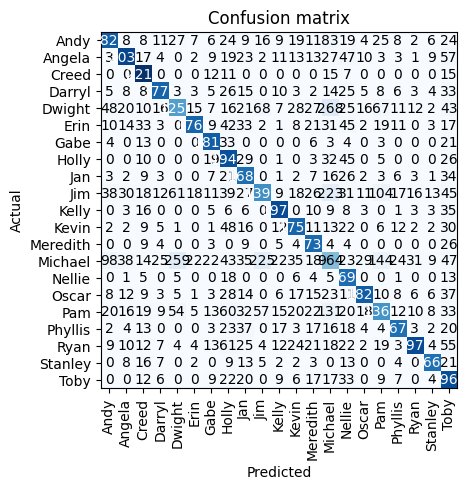

In [30]:
interp.plot_confusion_matrix()

In [31]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj i 've really learned from the xxunk . xxmaj the great xxunk , xxmaj drew xxmaj xxunk , xxmaj ryan xxmaj xxunk , uh , the xxmaj xxunk guy not so much . xxmaj he 's more the signing , xxmaj wayne xxmaj xxunk . xxmaj um , xxmaj robin xxmaj williams . xxmaj oh , man , would i love to go head - to - head with him . xxmaj oh ! xxmaj that would be exciting . [ as xxmaj robin xxmaj williams ] ' hi . xxmaj i 'm xxmaj xxunk from xxmaj xxunk . ' xxmaj well , xxmaj i 'm xxmaj xxunk from xxmaj xxunk . xxmaj nanoo , nanoo . xxmaj xxunk , xxunk . [ as xxmaj robin xxmaj williams ] ' that 's xxmaj good morning , xxmaj vietnam ! ' xxmaj well , hello to you . xxmaj",Michael,Michael
1,"xxbos xxmaj sales is about people , xxmaj ryan . xxmaj about understanding them and learning how to get along with them . xxmaj case study : me . xxmaj to understand me , you have to know that i work in the city , but i live here on this small , beautiful farm . xxmaj it 's a family farm . xxmaj many xxmaj schrutes were born here and many of us end up here . xxmaj my grandfather was a good man who did some very bad things . xxmaj what the … xxmaj damn it ! xxmaj those kids ! [ xxunk two teenagers naked , running ] xxmaj you ! xxmaj you , get out of here ! xxmaj this is not a cheap motel ! xxmaj this is a farm and cemetery ! xxmaj freaks ! xxmaj you 're lucky i do n't have",Dwight,Dwight
2,"xxbos [ to xxmaj andy ] i talked to corporate . xxmaj turns out there have been 12 reports of xxunk printers . xxmaj out of 400 , xxrep 3 0 . [ smiles ] xxmaj we 've xxunk . xxmaj every time it 's been user error . xxmaj they block the xxunk or something , i do n't know . xxmaj that 's why we have the fine print . xxmaj thank you for bringing this to our attention . xxmaj so xxmaj i 'd like to reward you for that . [ pulls out gift card ] xxmaj that 's god for five bucks at xxmaj dunkin ' xxmaj donuts . xxmaj any xxmaj dunkin ' xxmaj donuts . [ andy looks over at xxmaj darryl and xxmaj darryl motions for xxmaj andy to go to him ]",Gabe,Gabe
3,"xxbos i know . xxmaj here , xxmaj michael , you can court her as you get to know her , you know ? i mean , the office is a great place for that . xxmaj pam and xxup i , we got to know each other right out there . i mean , the first time we xxunk around was at my desk . xxmaj and the first meal we ever had was , in the break room , actually . xxmaj we were at two separate tables and , i remember that . xxmaj the first time we kissed even , was right outside , and … xxmaj look , all xxmaj i 'm saying is that you can get to know someone really really well , like i did , right here at work .",Jim,Jim
4,"xxbos xxmaj ok , yeah , this is a duet , so , need somebody else , xxmaj pam ? xxmaj you wanna come up and sing this one ? xxmaj need somebody else . xxmaj takers , please . [ singing ] xxmaj baby when i met you there was peace xxunk . xxmaj kelly ? xxmaj tried to get you with a fine tooth comb . i was soft inside , there was something goin' on . xxmaj this part goes to the , uh , girl . xxmaj you do something to me that i ca n't explain . xxmaj hold me closer and i feel no pain . xxmaj in every beat of my heart , we got something goin' on . xxmaj tender love is blind xxrep 3 -",Michael,Michael
5,"xxbos xxmaj no , nothing happened . xxup i - i swear , nothing happened . xxmaj what , xxmaj i 'm , totally being serious . a gentleman does not kiss and tell , and neither do xxup i. [ laughs ] xxmaj no , seriously , guys , xxmaj i 'm not , i do n't want to go into it at all . xxmaj it 's off limits . xxmaj fine , i took her back to her hotel and we made out for a little while . xxmaj it was great . i mean she told me about her divorce , we talked for about five hours , she fell asleep on my arm . xxmaj so .",Michael,Michael
6,"xxbos [ leaving a message ] xxmaj hey , xxmaj jan . xxmaj it 's me , xxmaj michael . xxmaj i 'm just calling to say that i think we need a little break , xxunk . xxmaj and , uh , i know e

In [33]:
learn.predict('I just wanna eat hot dogs on the beach')

('Dwight',
 tensor(4),
 tensor([5.2628e-02, 1.0969e-03, 4.1041e-04, 7.6654e-04, 3.0535e-01, 4.0382e-02,
         3.3135e-04, 6.6638e-04, 1.3470e-03, 1.5415e-01, 1.6243e-03, 3.5354e-02,
         1.8192e-02, 1.2011e-01, 3.1970e-03, 2.7637e-04, 1.5507e-01, 7.5096e-03,
         4.1389e-03, 5.9942e-03, 9.1411e-02]))

In [45]:
preds = learn.get_preds(dl=dls_test)

(tensor([[1.2369e-02, 3.2843e-04, 3.0447e-04,  ..., 2.4547e-03, 4.0259e-03,
          2.2854e-03],
         [4.8736e-03, 1.3806e-04, 4.5169e-04,  ..., 4.0938e-02, 7.7170e-03,
          1.6612e-03],
         [5.0698e-03, 2.4542e-04, 1.6575e-03,  ..., 2.6195e-03, 3.1493e-03,
          7.3937e-03],
         ...,
         [6.0663e-01, 4.3243e-03, 2.0941e-03,  ..., 2.9248e-04, 6.7132e-04,
          3.0139e-04],
         [4.2921e-02, 3.1240e-03, 6.6091e-05,  ..., 9.2646e-04, 2.1799e-03,
          3.9760e-04],
         [5.2641e-01, 7.8944e-05, 2.1872e-01,  ..., 3.0512e-02, 2.5013e-04,
          8.5143e-03]]),
 tensor([ 4,  4, 13,  ..., 15,  3, 11]))

In [46]:
accuracy(preds[0], preds[1])

TensorBase(0.1609)

In [47]:
preds[0]

tensor([[1.2369e-02, 3.2843e-04, 3.0447e-04,  ..., 2.4547e-03, 4.0259e-03,
         2.2854e-03],
        [4.8736e-03, 1.3806e-04, 4.5169e-04,  ..., 4.0938e-02, 7.7170e-03,
         1.6612e-03],
        [5.0698e-03, 2.4542e-04, 1.6575e-03,  ..., 2.6195e-03, 3.1493e-03,
         7.3937e-03],
        ...,
        [6.0663e-01, 4.3243e-03, 2.0941e-03,  ..., 2.9248e-04, 6.7132e-04,
         3.0139e-04],
        [4.2921e-02, 3.1240e-03, 6.6091e-05,  ..., 9.2646e-04, 2.1799e-03,
         3.9760e-04],
        [5.2641e-01, 7.8944e-05, 2.1872e-01,  ..., 3.0512e-02, 2.5013e-04,
         8.5143e-03]])

In [48]:
preds[1]

tensor([ 4,  4, 13,  ..., 15,  3, 11])

In [49]:
len(preds)

2

In [52]:
preds = learn.get_preds(dl=dls_clas.train)

(tensor([[9.0454e-10, 3.8743e-08, 1.5522e-09,  ..., 8.1625e-09, 9.1371e-09,
          3.1704e-09],
         [4.6497e-08, 9.7892e-08, 5.9329e-08,  ..., 2.2585e-08, 6.1379e-08,
          6.0413e-08],
         [1.9041e-07, 9.2675e-07, 2.1577e-09,  ..., 9.6342e-08, 1.6669e-08,
          1.2099e-07],
         ...,
         [5.0192e-09, 7.9900e-09, 2.2145e-08,  ..., 3.3514e-09, 8.5434e-08,
          2.5736e-09],
         [2.0284e-08, 1.1289e-06, 1.0579e-09,  ..., 1.7047e-06, 3.3365e-08,
          2.8043e-07],
         [3.0127e-07, 1.8228e-08, 1.7321e-09,  ..., 2.6182e-07, 2.2698e-09,
          1.4810e-08]]),
 tensor([14, 14, 16,  ..., 17, 16, 11]))

In [53]:
accuracy(preds[0], preds[1])

TensorBase(0.9108)

In [58]:
preds = learn.get_preds(dl=dls_clas.valid)

(tensor([[1.3650e-07, 1.4490e-08, 9.5382e-11,  ..., 2.1227e-06, 4.9836e-09,
          1.5772e-06],
         [1.3573e-08, 3.2385e-08, 1.2901e-08,  ..., 5.3374e-08, 3.3489e-09,
          9.7293e-08],
         [3.9616e-04, 2.7686e-02, 1.0129e-05,  ..., 5.4241e-04, 2.4623e-02,
          1.4098e-03],
         ...,
         [4.5492e-02, 1.9176e-02, 4.0175e-02,  ..., 4.5723e-02, 9.2583e-03,
          7.5023e-02],
         [1.6725e-04, 3.2066e-06, 1.6237e-07,  ..., 9.9908e-01, 2.0526e-07,
          1.2976e-06],
         [2.4908e-11, 3.0355e-11, 1.2169e-06,  ..., 7.4533e-09, 1.5418e-08,
          2.3982e-10]]),
 tensor([ 9,  8, 13,  ..., 18, 18, 17]))

In [59]:
accuracy(preds[0], preds[1])

TensorBase(0.8536)